# Building the Case for Complexity

## License 

Copyright 2017 - 2020 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

In [1]:
# TODO:
#   only print comparison bar chart for best MGBM
#   ...

#### Python imports 

In [2]:
import h2o                                                        # import h2o python bindings to java server
from h2o.estimators.glm import H2OGeneralizedLinearEstimator      # for benchmark model
from h2o.grid.grid_search import H2OGridSearch                    # for benchmark model
from h2o.estimators.gbm import H2OGradientBoostingEstimator       # for GBM
import numpy as np                                                # array, vector, matrix calculations
import pandas as pd                                               # DataFrame handling
import shap                                                       # for consistent, signed variable importance measurements
import xgboost as xgb                                             # gradient boosting machines (GBMs)

import matplotlib.pyplot as plt      # plotting
import seaborn as sns                # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

SEED = 12345
np.random.seed(SEED)                # set random seed for reproducibility

h2o.init()

/home/patrickh/workspace/interpretable_machine_learning_with_python/env_iml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_242"; OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~16.04-b08); OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)
  Starting server from /home/patrickh/workspace/interpretable_machine_learning_with_python/env_iml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptse3r2lm
  JVM stdout: /tmp/tmptse3r2lm/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmptse3r2lm/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,7 months and 16 days !!!
H2O cluster name:,H2O_from_python_patrickh_qi1q3r
H2O cluster total nodes:,1
H2O cluster free memory:,3.462 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [5]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. Investigate pair-wise Pearson correlations for DEFAULT_NEXT_MONTH

#### Calculate Pearson correlation

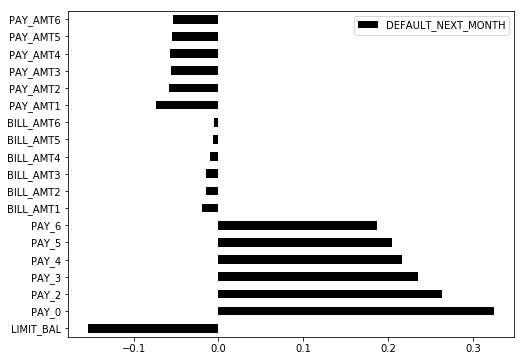

In [6]:
corr = pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']

# display correlation matrix as barchart
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')

In [7]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


In [8]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    
    # define search criteria
    # i.e. over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts} 

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="binomial",
            lambda_search=True,
            seed=SEED),
        hyper_params=hyper_parameters)
    
    # run grid search
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # select best model from grid search
    return grid.get_grid()[0]

best_glm = glm_grid(X, y, h2o.H2OFrame(train), h2o.H2OFrame(test))
print('Best penalized GLM AUC: %.2f' % 
      best_glm.auc(valid=True))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
Best penalized GLM AUC: 0.73


In [9]:
best_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_ac78ba9994fbfed5576f485c5ee74446.hex_model_python_1586445532912_1_model_1


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.01, lambda = 0.005908 )","nlambda = 100, lambda.max = 13.333, lambda.min = 0.005908, lambda....",19,19,109,Key_Frame__upload_ac78ba9994fbfed5576f485c5ee74446.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.14649158915954694
RMSE: 0.3827421967324049
LogLoss: 0.4685812636002606
Null degrees of freedom: 20945
Residual degrees of freedom: 20926
Null deviance: 22178.75361964548
Residual deviance: 19629.806294742117
AIC: 19669.806294742117
AUC: 0.7182752479663853
pr_auc: 0.5010322496049208
Gini: 0.4365504959327706

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24983106738243732: 

,,0,1,Error,Rate
0,0,13778.0,2518.0,0.1545,(2518.0/16296.0)
1,1,2168.0,2482.0,0.4662,(2168.0/4650.0)
2,Total,15946.0,5000.0,0.2237,(4686.0/20946.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.249831,0.514404,205.0
1,max f2,0.054654,0.594059,377.0
2,max f0point5,0.399178,0.567555,137.0
3,max accuracy,0.418922,0.817053,128.0
4,max precision,0.706802,0.797414,34.0
5,max recall,0.001281,1.000000,399.0
6,max specificity,0.989212,0.999570,0.0
7,max absolute_mcc,0.399178,0.396395,137.0
8,max min_per_class_accuracy,0.221641,0.658925,237.0
9,max mean_per_class_accuracy,0.245211,0.690483,210.0



Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.20 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010026,7.192943e-01,3.539263,3.539263,0.785714,0.816889,0.785714,0.816889,0.035484,0.035484,253.926267,253.926267
1,,2,0.020004,6.109553e-01,2.952721,3.246692,0.655502,0.659815,0.720764,0.738540,0.029462,0.064946,195.272110,224.669182
2,,3,0.030030,5.904669e-01,3.303312,3.265595,0.733333,0.600522,0.724960,0.692461,0.033118,0.098065,230.331183,226.559516
3,,4,0.040008,5.652261e-01,3.469986,3.316571,0.770335,0.576997,0.736277,0.663664,0.034624,0.132688,246.998611,231.657094
4,,5,0.050033,5.378222e-01,3.024461,3.258037,0.671429,0.552092,0.723282,0.641307,0.030323,0.163011,202.446083,225.803743
5,,6,0.100019,4.442181e-01,2.916965,3.087582,0.647564,0.484561,0.685442,0.562971,0.145806,0.308817,191.696460,208.758242
6,,7,0.150005,3.537487e-01,2.090922,2.755468,0.464183,0.405265,0.611712,0.510419,0.104516,0.413333,109.092153,175.546785
7,,8,0.200038,2.655100e-01,1.427003,2.423193,0.316794,0.294731,0.537947,0.456471,0.071398,0.484731,42.700320,142.319316
8,,9,0.300010,2.382281e-01,1.015345,1.954060,0.225406,0.248630,0.433800,0.387213,0.101505,0.586237,1.534461,95.405967
9,,10,0.400029,2.224902e-01,0.672990,1.633754,0.149403,0.229921,0.362692,0.347885,0.067312,0.653548,-32.701024,63.375397




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.14363466020798765
RMSE: 0.3789916360660056
LogLoss: 0.4617337838828071
Null degrees of freedom: 9053
Residual degrees of freedom: 9034
Null deviance: 9526.71172610569
Residual deviance: 8361.075358549871
AIC: 8401.075358549871
AUC: 0.7303402396287311
pr_auc: 0.5061676572465437
Gini: 0.46068047925746214

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2607285198255573: 

,,0,1,Error,Rate
0,0,6083.0,985.0,0.1394,(985.0/7068.0)
1,1,921.0,1065.0,0.4637,(921.0/1986.0)
2,Total,7004.0,2050.0,0.2105,(1906.0/9054.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.260729,0.527750,193.0
1,max f2,0.116430,0.592436,329.0
2,max f0point5,0.400670,0.576923,134.0
3,max accuracy,0.433434,0.822288,120.0
4,max precision,0.572358,0.743386,68.0
5,max recall,0.007410,1.000000,397.0
6,max specificity,0.989045,0.999859,0.0
7,max absolute_mcc,0.370892,0.413902,147.0
8,max min_per_class_accuracy,0.225699,0.672205,230.0
9,max mean_per_class_accuracy,0.246401,0.699498,206.0



Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010051,7.207631e-01,3.106072,3.106072,0.681319,0.813734,0.681319,0.813734,0.031219,0.031219,210.607218,210.607218
1,,2,0.020102,6.229843e-01,3.156170,3.131121,0.692308,0.663736,0.686813,0.738735,0.031722,0.062941,215.617011,213.112114
2,,3,0.030042,5.993452e-01,3.545821,3.268338,0.777778,0.607299,0.716912,0.695245,0.035247,0.098187,254.582075,226.833792
3,,4,0.040093,5.753741e-01,3.757345,3.390927,0.824176,0.587697,0.743802,0.668284,0.037764,0.135952,275.734537,239.092657
4,,5,0.050033,5.509826e-01,3.241893,3.361317,0.711111,0.562950,0.737307,0.647357,0.032226,0.168177,224.189325,236.131730
5,,6,0.100066,4.545088e-01,2.968828,3.165073,0.651214,0.496126,0.694260,0.571741,0.148540,0.316717,196.882815,216.507273
6,,7,0.149989,3.741888e-01,2.208854,2.846802,0.484513,0.414835,0.624448,0.519516,0.110272,0.426989,120.885357,184.680243
7,,8,0.200022,2.740947e-01,1.489446,2.507276,0.326711,0.315894,0.549972,0.468582,0.074522,0.501511,48.944599,150.727595
8,,9,0.299978,2.407348e-01,0.997420,2.004176,0.218785,0.253042,0.439617,0.396762,0.099698,0.601208,-0.258049,100.417577
9,,10,0.400044,2.249573e-01,0.719563,1.682845,0.157837,0.232429,0.369133,0.355656,0.072004,0.673212,-28.043657,68.284535




Scoring History: 

,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
0,,2020-04-09 11:18:59,0.000 sec,1,.13E2,1,1.058854,1.052210
1,,2020-04-09 11:18:59,0.041 sec,2,.12E2,2,1.058595,1.051942
2,,2020-04-09 11:18:59,0.066 sec,3,.11E2,2,1.058312,1.051649
3,,2020-04-09 11:18:59,0.115 sec,4,.1E2,3,1.057846,1.051165
4,,2020-04-09 11:18:59,0.140 sec,5,.92E1,4,1.057200,1.050494
5,,2020-04-09 11:18:59,0.166 sec,6,.84E1,5,1.056328,1.049589
6,,2020-04-09 11:18:59,0.194 sec,7,.76E1,6,1.055193,1.048412
7,,2020-04-09 11:18:59,0.214 sec,8,.7E1,7,1.053849,1.047023
8,,2020-04-09 11:18:59,0.250 sec,9,.63E1,7,1.052407,1.045532
9,,2020-04-09 11:18:59,0.279 sec,10,.58E1,8,1.050810,1.043879



See the whole table with table.as_data_frame()


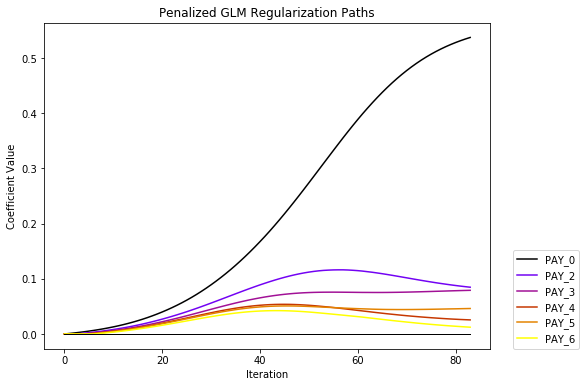

In [10]:
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())

for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)
    
selected = list(reg_path_frame.iloc[-1, :][reg_path_frame.iloc[-1, :] > 1e-03].index)

fig, ax_ = plt.subplots(figsize=(8, 6))
_ = reg_path_frame[selected].plot(kind='line', ax=ax_, title='Penalized GLM Regularization Paths',
                                  colormap='gnuplot')
_ = ax_.set_xlabel('Iteration')
_ = ax_.set_ylabel('Coefficient Value')
_ = ax_.axhline(c='k', lw=1, xmin=0.045, xmax=0.955)
_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

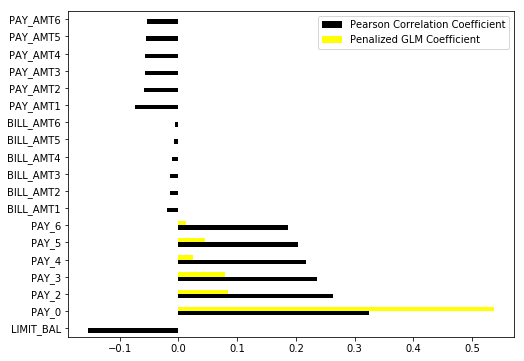

In [11]:
glm_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])
corr_glm = pd.concat([corr,glm_coef.iloc[1:]], axis=1)

fig, ax_ = plt.subplots(figsize=(8, 6))
_ = corr_glm.plot(kind='barh', ax=ax_, colormap='gnuplot')

#### Train Monotonic XGBoost GBM classifier

In [12]:
def mgbm_grid(X, mc): 
    
    # define random grid search parameters
    hyper_parameters = {'ntrees':list(range(1, 500, 50)),
                        'max_depth':list(range(1, 20, 2)),
                        'sample_rate':[s/float(10) for s in range(1, 11)],
                        'col_sample_rate':[s/float(10) for s in range(1, 11)]}

    # define search strategy
    search_criteria = {'strategy':'RandomDiscrete',
                       'max_models':20,
                       'max_runtime_secs':600,
                       'seed': SEED}

    # initialize grid search
    gsearch = H2OGridSearch(H2OGradientBoostingEstimator,
                            hyper_params=hyper_parameters,
                            search_criteria=search_criteria)

    # execute training w/ grid search
    gsearch.train(x=X,
                  y=y,
                  monotone_constraints=mc,
                  training_frame=htrain,
                  validation_frame=htest,
                  stopping_rounds=5,
                  seed=SEED)
    
    
    mgbm_model = gsearch.get_grid()[0]

    return mgbm_model
    

In [13]:
#### initialize data structures needed to compare correlation coefficients,
# penalized glm coefficients, and MGBM Shapley values
# as features are added into the MGBM

# create a list of features to add into MGBM
# list is ordered by correlation between X_j and y
abs_corr = corr.copy(deep=True)
abs_corr['Pearson Correlation Coefficient'] = corr['Pearson Correlation Coefficient'].abs()
X_selected = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
next_list = [name for name in list(abs_corr.sort_values(by='Pearson Correlation Coefficient',
                                                        ascending=False).index) if name not in X_selected]

# create a Pandas DataFrame to store new MGBM SHAP values
# for comparison to correlation and penalized gbm coefficients
abs_corr_glm_mgbm_shap = corr_glm.copy(deep=True).abs()
abs_corr_glm_mgbm_shap.columns = ['Absolute ' + name for name in abs_corr_glm_mgbm_shap.columns]
abs_corr_glm_mgbm_shap['Monotonic GBM Mean SHAP Value'] = 0

# init empty parallel lists to store results 
mgbm_models = []
corr_glm_mgbm_shap_coefs = []

#### train multiple MGBMs
# each time adding in the next most y-correlated feature
for j, name in enumerate(next_list):

    # create monotonicity contraints for the current model
    names = list(test[X_selected + [y]].corr()[y].index)[:-1]
    signs = list([int(i) for i in np.sign(test[X_selected + [y]].corr()[y].values[:-1])])
    mc = dict(zip(names, signs))

    # convert training and test data to h2o format
    htrain = h2o.H2OFrame(train[X_selected + [y]]) # necessary to ensure ordering of Shapley values matches X_selected
    htrain[y] = htrain[y].asfactor()               # ensure y is treated as binomial
    htest = h2o.H2OFrame(test[X_selected + [y]])
    
    # train model and calculate Shapley values
    mgbm_models.append(mgbm_grid(X_selected, mc))
    shap_values = mgbm_models[j].predict_contributions(htest).as_data_frame().values[:,:-1]
    
    # update Pandas dataframe with current model Shapley values
    col = pd.DataFrame({'Monotonic GBM Mean SHAP Value': 
                        list(np.abs(shap_values).mean(axis=0))}, index=X_selected)
    abs_corr_glm_mgbm_shap.update(col)
    corr_glm_mgbm_shap_coefs.append(abs_corr_glm_mgbm_shap.copy(deep=True)) # deep copy necessary
    
    # retrieve AUC and print progress
    auc_ = mgbm_models[j].auc(valid=True)
    print('Completed grid search %i/%i with AUC: %.2f ...\n' % (j+1, len(next_list), auc_))
      
    # add the next most y-correlated feature
    # for the next modeling iteration
    X_selected = X_selected + [next_list[j]]
    
print('Done.')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Completed grid search 1/13 with AUC: 0.74 ...

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Completed grid search 2/13 with AUC: 0.76 ...

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Completed grid search 3/13 with AUC: 0.77 ...

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |████████████████████████████████

#### Plot results

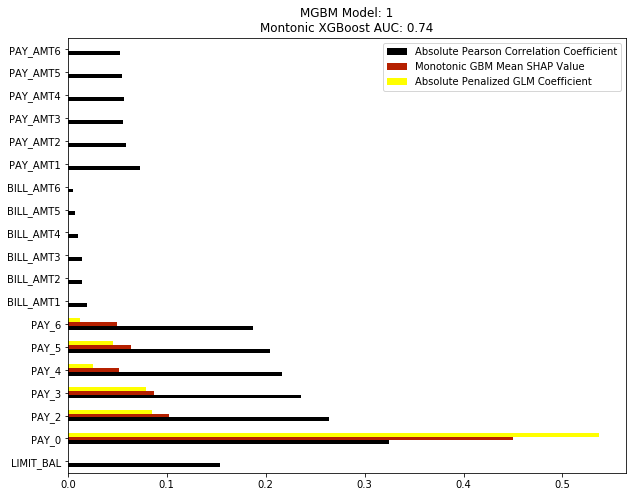

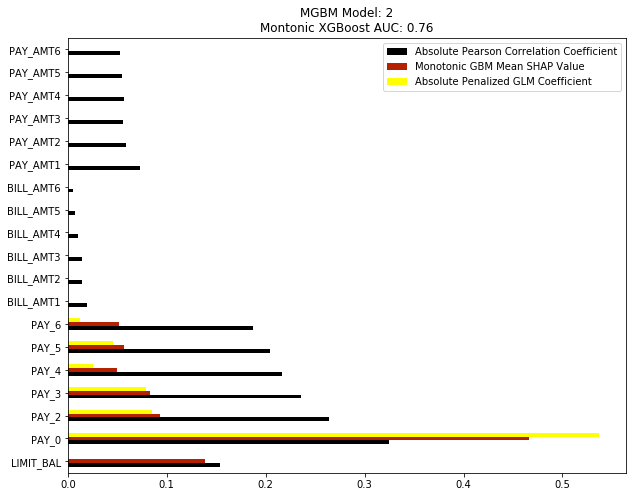

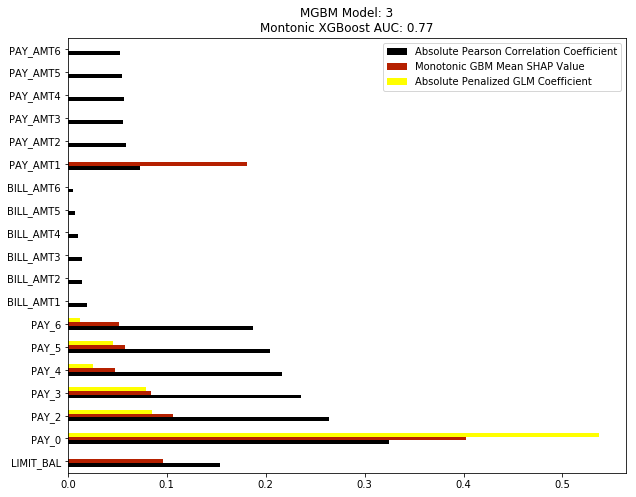

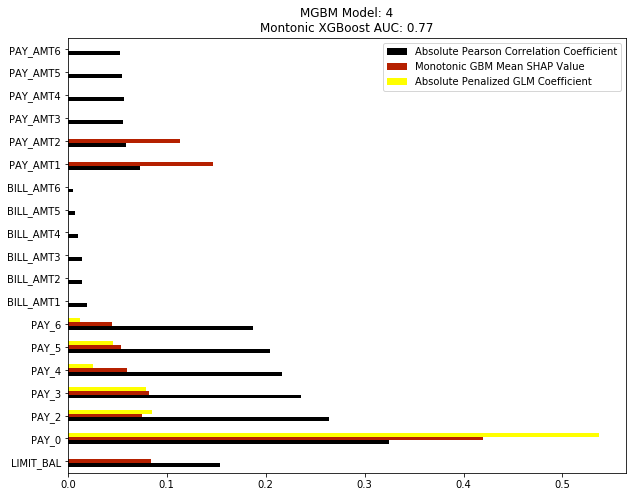

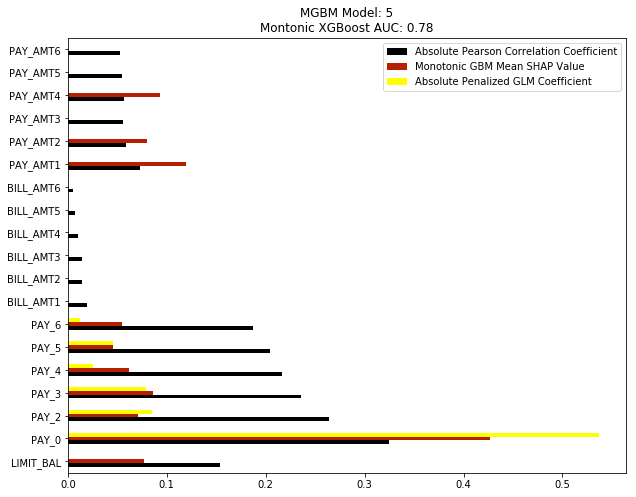

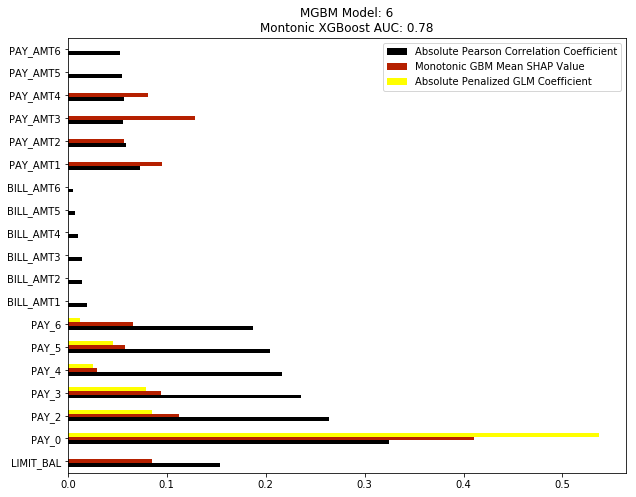

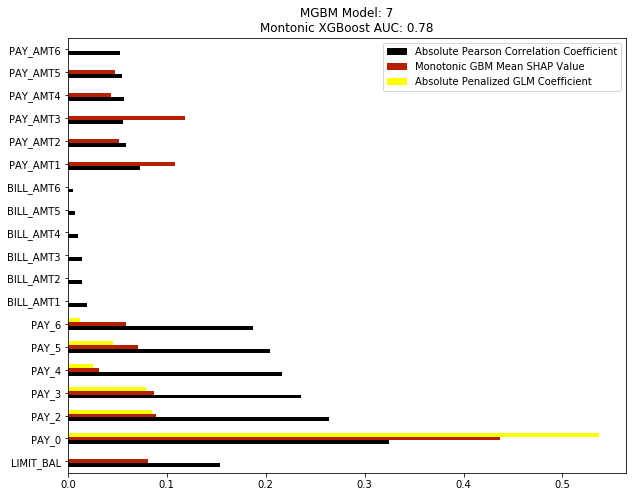

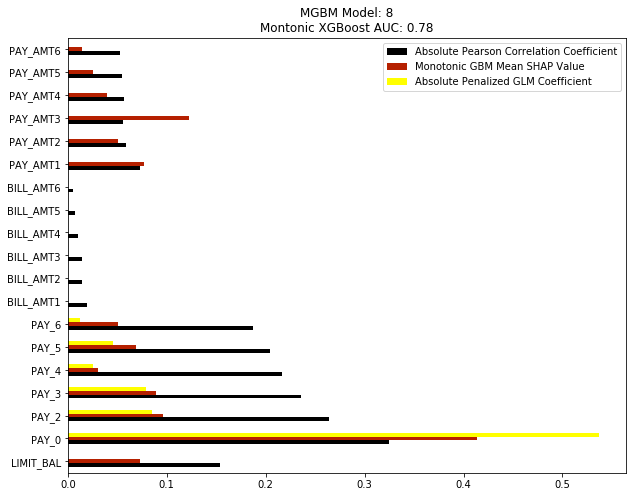

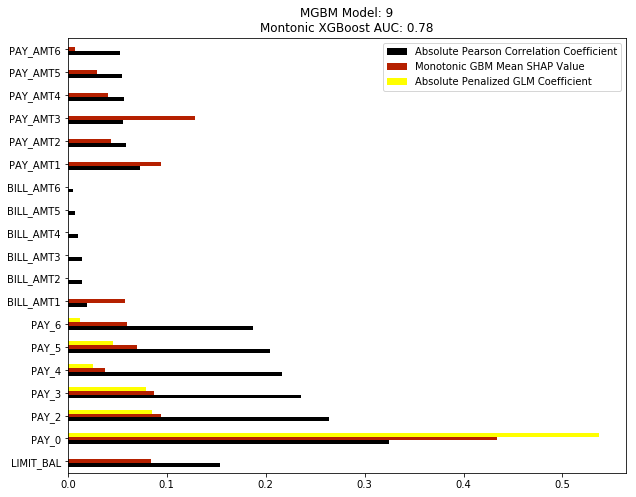

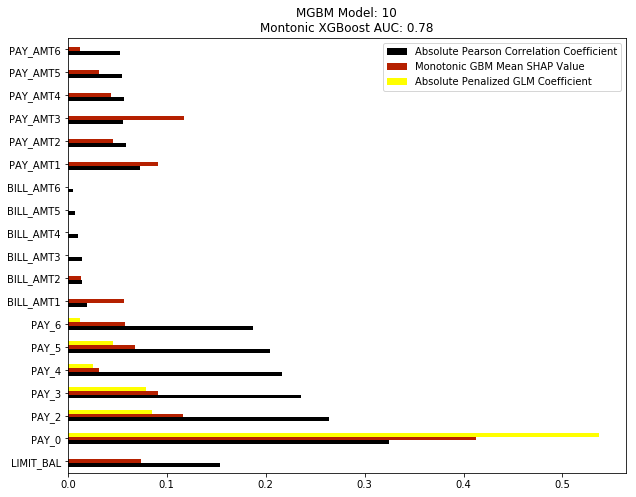

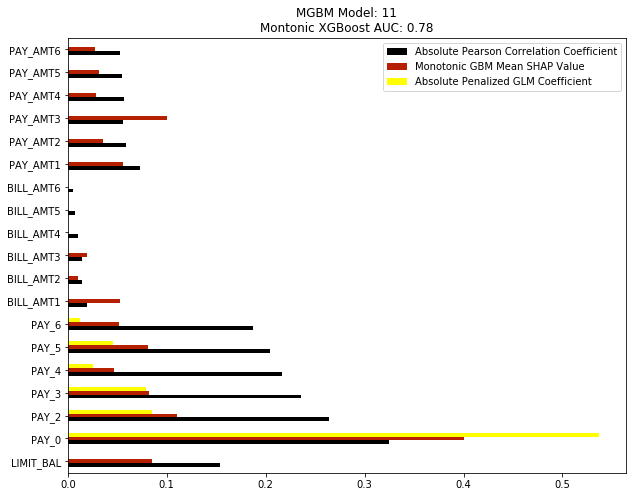

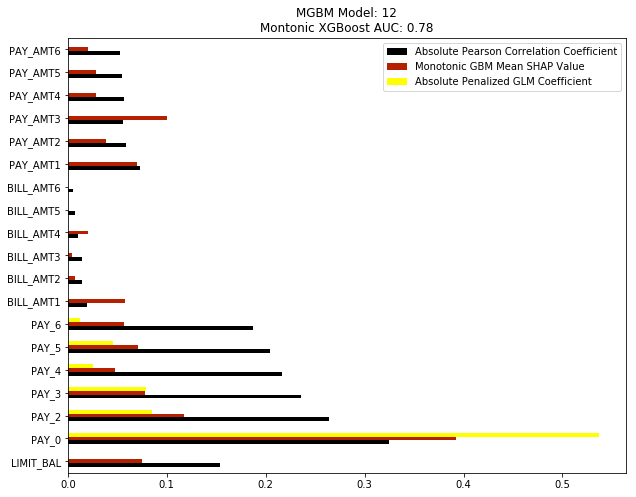

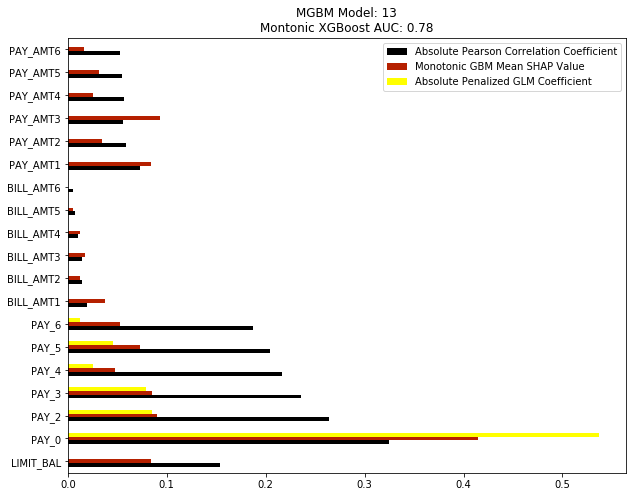

In [165]:
for j, frame in enumerate(corr_glm_mgbm_shap_coefs):
    
    # plot results
    auc_ = mgbm_models[j].auc(valid=True)
    title_ = 'MGBM Model: {j}\nMontonic XGBoost AUC: {auc:.2f}'.format(j=str(j+1), auc=auc_)     
    fig, ax_ = plt.subplots(figsize=(10, 8))
    _ = frame[['Absolute Pearson Correlation Coefficient',
               'Monotonic GBM Mean SHAP Value',
               'Absolute Penalized GLM Coefficient']].plot(kind='barh',
                                                           ax=ax_, 
                                                           title=title_,
                                                           colormap='gnuplot')

In [166]:
best_idx = 5
best_mgbm = mgbm_models[best_idx-1]
selected_coefs = corr_glm_mgbm_shap_coefs[best_idx-1]
best_mgbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_py_5_sid_a7b5_model_python_1586445532912_7618_model_18


Model Summary: 

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,46.0,46.0,6939.0,3.0,3.0,3.0,5.0,8.0,7.369565




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1363771986430037
RMSE: 0.3692928358945022
LogLoss: 0.4351274080189964
Mean Per-Class Error: 0.2915014965081477
AUC: 0.7716912455593035
pr_auc: 0.5472451346416678
Gini: 0.5433824911186069

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2197639481136088: 

,,0,1,Error,Rate
0,0,13482.0,2814.0,0.1727,(2814.0/16296.0)
1,1,1908.0,2742.0,0.4103,(1908.0/4650.0)
2,Total,15390.0,5556.0,0.2254,(4722.0/20946.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.219764,0.537331,247.0
1,max f2,0.127441,0.630748,329.0
2,max f0point5,0.445082,0.583034,149.0
3,max accuracy,0.445082,0.821446,149.0
4,max precision,0.950247,1.000000,0.0
5,max recall,0.050609,1.000000,395.0
6,max specificity,0.950247,1.000000,0.0
7,max absolute_mcc,0.325289,0.413418,194.0
8,max min_per_class_accuracy,0.177539,0.698280,280.0
9,max mean_per_class_accuracy,0.219764,0.708499,247.0



Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.00 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010074,0.813927,3.607883,3.607883,0.800948,0.843446,0.800948,0.843446,0.036344,0.036344,260.788259,260.788259
1,,2,0.020338,0.795575,3.519808,3.563432,0.781395,0.805153,0.791080,0.824119,0.036129,0.072473,251.980795,256.343177
2,,3,0.030316,0.763679,3.405328,3.511394,0.755981,0.783970,0.779528,0.810905,0.033978,0.106452,240.532798,251.139446
3,,4,0.040008,0.715138,3.261891,3.450954,0.724138,0.739815,0.766110,0.793684,0.031613,0.138065,226.189099,245.095388
4,,5,0.050081,0.664416,3.116869,3.383755,0.691943,0.686695,0.751192,0.772164,0.031398,0.169462,211.686898,238.375473
5,,6,0.100019,0.543384,2.859463,3.121984,0.634799,0.601794,0.693079,0.687101,0.142796,0.312258,185.946339,212.198445
6,,7,0.150005,0.366237,2.224293,2.822849,0.493792,0.446951,0.626671,0.607076,0.111183,0.423441,122.429306,182.284922
7,,8,0.205672,0.292765,1.595510,2.490659,0.354202,0.312777,0.552925,0.527422,0.088817,0.512258,59.551043,149.065864
8,,9,0.301251,0.196648,1.174504,2.073077,0.260739,0.234499,0.460222,0.434485,0.112258,0.624516,17.450421,107.307684
9,,10,0.400029,0.173817,0.864327,1.774604,0.191880,0.184844,0.393961,0.372842,0.085376,0.709892,-13.567284,77.460410




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13326994104124376
RMSE: 0.3650615578792757
LogLoss: 0.4278285715046422
Mean Per-Class Error: 0.2856607030196092
AUC: 0.7776380047998697
pr_auc: 0.5486322626112021
Gini: 0.5552760095997393

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27397344199105433: 

,,0,1,Error,Rate
0,0,6093.0,975.0,0.1379,(975.0/7068.0)
1,1,863.0,1123.0,0.4345,(863.0/1986.0)
2,Total,6956.0,2098.0,0.203,(1838.0/9054.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.273973,0.549951,217.0
1,max f2,0.147835,0.634488,307.0
2,max f0point5,0.436620,0.590736,153.0
3,max accuracy,0.456963,0.825271,147.0
4,max precision,0.947069,1.000000,0.0
5,max recall,0.045106,1.000000,397.0
6,max specificity,0.947069,1.000000,0.0
7,max absolute_mcc,0.347246,0.429999,184.0
8,max min_per_class_accuracy,0.181585,0.709970,275.0
9,max mean_per_class_accuracy,0.230518,0.714339,240.0



Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.52 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011155,0.815010,3.295055,3.295055,0.722772,0.839858,0.722772,0.839858,0.036757,0.036757,229.505549,229.505549
1,,2,0.020543,0.795575,3.700764,3.480460,0.811765,0.805631,0.763441,0.824217,0.034743,0.071501,270.076417,248.045999
2,,3,0.030042,0.783550,3.604721,3.519749,0.790698,0.792441,0.772059,0.814170,0.034240,0.105740,260.472142,251.974853
3,,4,0.040093,0.743192,3.005876,3.390927,0.659341,0.761335,0.743802,0.800925,0.030211,0.135952,200.587630,239.092657
4,,5,0.050033,0.697702,3.444512,3.401573,0.755556,0.723091,0.746137,0.785461,0.034240,0.170191,244.451158,240.157260
5,,6,0.101281,0.553193,3.104777,3.251394,0.681034,0.614736,0.713195,0.699075,0.159114,0.329305,210.477654,225.139444
6,,7,0.150320,0.383564,2.187046,2.904171,0.479730,0.466067,0.637032,0.623061,0.107251,0.436556,118.704581,190.417123
7,,8,0.200022,0.296915,1.580423,2.575244,0.346667,0.327817,0.564881,0.549698,0.078550,0.515106,58.042296,157.524427
8,,9,0.301303,0.203539,1.133514,2.090616,0.248637,0.250648,0.458578,0.449174,0.114804,0.629909,13.351366,109.061561
9,,10,0.403468,0.176970,0.961068,1.804595,0.210811,0.187190,0.395839,0.382836,0.098187,0.728097,-3.893198,80.459549




Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-04-09 11:21:12,25.516 sec,0.0,0.415591,0.529427,0.500000,0.000000,1.000000,0.778001,0.413815,0.526105,0.500000,0.000000,1.000000,0.780649
1,,2020-04-09 11:21:12,25.530 sec,1.0,0.407822,0.511864,0.716131,0.534717,3.474912,0.236370,0.405538,0.507496,0.726731,0.537125,3.444264,0.187652
2,,2020-04-09 11:21:12,25.543 sec,2.0,0.401483,0.498746,0.744646,0.532172,3.529706,0.228731,0.398808,0.493698,0.752909,0.534588,3.422307,0.232825
3,,2020-04-09 11:21:12,25.556 sec,3.0,0.396471,0.489013,0.748189,0.535621,3.529706,0.228636,0.393394,0.483273,0.756448,0.535692,3.422307,0.214491
4,,2020-04-09 11:21:12,25.568 sec,4.0,0.392442,0.481430,0.750121,0.535358,3.529706,0.210780,0.389030,0.475135,0.758511,0.536095,3.422307,0.217915
5,,2020-04-09 11:21:12,25.581 sec,5.0,0.389141,0.475375,0.750058,0.535198,3.529706,0.245059,0.385453,0.468630,0.758505,0.535659,3.422307,0.214270
6,,2020-04-09 11:21:12,25.595 sec,6.0,0.386399,0.470332,0.756986,0.535024,3.529706,0.243961,0.382447,0.463157,0.764722,0.536039,3.422307,0.229843
7,,2020-04-09 11:21:12,25.609 sec,7.0,0.384191,0.466316,0.757005,0.535418,3.529706,0.243961,0.380045,0.458834,0.764634,0.536411,3.422307,0.220013
8,,2020-04-09 11:21:12,25.622 sec,8.0,0.382341,0.462760,0.761106,0.540176,3.514359,0.247446,0.378063,0.455049,0.770340,0.542043,3.457524,0.204330
9,,2020-04-09 11:21:12,25.635 sec,9.0,0.380701,0.459589,0.762515,0.540880,3.518279,0.235654,0.376184,0.451464,0.772358,0.543522,3.457524,0.223548



See the whole table with table.as_data_frame()

Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,PAY_0,2794.444824,1.000000,0.693347
1,PAY_2,307.237366,0.109946,0.076231
2,PAY_3,215.152893,0.076993,0.053383
3,PAY_4,155.434448,0.055623,0.038566
4,PAY_AMT1,127.986313,0.045800,0.031755
5,PAY_5,127.538628,0.045640,0.031644
6,PAY_6,102.351601,0.036627,0.025395
7,LIMIT_BAL,82.432350,0.029499,0.020453
8,PAY_AMT2,58.934135,0.021090,0.014623
9,PAY_AMT4,58.858047,0.021063,0.014604


## 4. Calculating partial dependence and ICE to validate and explain monotonic behavior

Goal is to have histogram, pdp, ice and box plot for each feature and then see if there is any need for non-monotonicity

In [167]:
pd_ice_dict = {}

#### Function for calculating partial dependence

In [168]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: 
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        # modify max and by 
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))    

    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    tframe = frame.copy(deep=True)
    tframe.loc[:, xs] = bins[0]
    for j, _ in enumerate(bins): 
        if j+1 < len(bins): 
            frame.loc[:, xs] = bins[j+1]
            tframe = tframe.append(frame, ignore_index=True)

    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache        
            
    # model predictions
    tframe['partial_dependence'] = model.predict(h2o.H2OFrame(tframe))['p1'].as_data_frame()
    
    return pd.DataFrame(tframe[[xs, 'partial_dependence']].groupby([xs]).mean()).reset_index()


#### Calculate partial dependence for the most important input variables in the GBM
The partial dependence for `LIMIT_BAL` can be seen to decrease as credit balance limits increase. This finding is aligned with expectations that the model predictions will be monotonically decreasing with increasing `LIMIT_BAL` and parsimonious with well-known business practices in credit lending. Partial dependence for other important values is displayed in plots further below.

In [169]:
selected = list(selected_coefs[selected_coefs['Monotonic GBM Mean SHAP Value'] != 0].index)

for xs in selected:
    pd_ice_dict[xs] = par_dep(xs, test, best_mgbm)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

#### Helper function for finding percentiles of predictions

In [170]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict


#### Find some percentiles of yhat in the test data
The values for `ID` that correspond to the maximum, minimum, and deciles of `p_DEFAULT_NEXT_MONTH` are displayed below. ICE will be calculated for the rows of the test dataset associated with these `ID` values.

In [171]:
# merge GBM predictions onto test data
yhat_test = pd.concat([test.reset_index(drop=True),
                       best_mgbm.predict(h2o.H2OFrame(test))['p1'].as_data_frame()],
                      axis=1)

yhat_test = yhat_test.rename(columns={'p1':'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


{0: 6593,
 99: 17863,
 10: 23504,
 20: 15919,
 30: 1919,
 40: 22205,
 50: 12297,
 60: 1847,
 70: 12644,
 80: 29479,
 90: 7682}

#### Calculate ICE curve values
ICE values represent a model's prediction for a row of data while an input variable of interest is varied across its domain. The values of the input variable are chosen to match the values at which partial dependence was calculated earlier, and ICE is calculated for the top three most important variables and for rows at each percentile of the test dataset. 

In [172]:
# loop though important variables
for xs in selected: 

    bins = list(pd_ice_dict[xs][xs])

    for i in sorted(percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        pd_ice_dict[xs][col_name] = par_dep(xs, 
                                            test[test['ID'] == int(percentile_dict[i])][selected], 
                                            best_mgbm, 
                                            bins=bins)['partial_dependence']
       

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |██

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

#### Display partial dependence and ICE for `LIMIT_BAL`
Partial dependence and ICE values for rows at the minimum, maximum and deciles (0%, 10%, 20%, ..., 90%, 99%) of predictions for `DEFAULT_NEXT_MONTH` and at the values of `LIMIT_BAL` used for partial dependence are shown here. Each column of ICE values will be a curve in the plots below. ICE values represent a prediction for a row of test data, at a percentile of interest noted in the column name above, and setting `LIMIT_BAL` to the value of `LIMIT_BAL` at right. Notice that monotonic decreasing prediction behavior for `LIMIT_BAL` holds at each displayed percentile of predicted `DEFAULT_NEXT_MONTH`, helping to validate that the trained GBM predictions are monotonic for `LIMIT_BAL`.

In [173]:
pd_ice_dict['PAY_0']

,PAY_0,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-2.000,0.171612,0.034810,0.091022,0.101455,0.115062,0.131647,0.152028,0.176970,0.203539,0.295223,0.136520,0.753545
1,-1.475,0.171765,0.034810,0.091022,0.101455,0.115062,0.131647,0.152028,0.176970,0.203539,0.295223,0.136520,0.755090
2,-0.950,0.171765,0.034810,0.091022,0.101455,0.115062,0.131647,0.152028,0.176970,0.203539,0.295223,0.136520,0.755090
3,-0.425,0.171995,0.034810,0.091861,0.102380,0.115062,0.132806,0.152028,0.176970,0.203539,0.295223,0.136520,0.755090
4,0.100,0.171995,0.034810,0.091861,0.102380,0.115062,0.132806,0.152028,0.176970,0.203539,0.295223,0.136520,0.755090
5,0.625,0.252567,0.060496,0.151440,0.162878,0.191333,0.189043,0.242982,0.268686,0.303940,0.354464,0.215430,0.815980
6,1.150,0.252567,0.060496,0.151440,0.162878,0.191333,0.189043,0.242982,0.268686,0.303940,0.354464,0.215430,0.815980
7,1.675,0.530825,0.198389,0.501268,0.522847,0.536538,0.507322,0.583980,0.596890,0.466341,0.659349,0.553193,0.943493
8,2.200,0.530825,0.198389,0.501268,0.522847,0.536538,0.507322,0.583980,0.596890,0.466341,0.659349,0.553193,0.943493
9,2.725,0.532133,0.198389,0.501268,0.522847,0.536538,0.508410,0.583980,0.596890,0.466341,0.660326,0.553193,0.947069


## 5. Plotting partial dependence and ICE to validate and explain monotonic behavior

Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local monotonic behavior. Plots of partial dependence curves overlayed onto ICE curves for several percentiles of predictions for `DEFAULT_NEXT_MONTH` are used to validate monotonic behavior, describe the GBM model mechanisms, and to compare the most extreme GBM behavior with the average GBM behavior in the test data. Partial dependence and ICE plots are displayed for the three most important variables in the GBM: `PAY_0`, `LIMIT_BAL`, and `BILL_AMT1`.

In [174]:
def plot_par_dep_ICE(xs, par_dep_frame, ax=None):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    Conditionally uses user-defined axes, ticks, and labels for grouped subplots.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
        ax: Matplotlib axis object to use, default None.         
    
    """
    
    # for standalone plotting
    if ax is None:
        
        # initialize figure and axis
        fig, ax = plt.subplots()
        
        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                              colormap='coolwarm', 
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE: ' + xs,
                           x=xs, 
                           y='partial_dependence',
                           color='grey', 
                           linewidth=3, 
                           ax=ax)
    
    # for grouped subplots 
    else: 
        
        # plot ICE
        par_dep_frame.plot(x=xs, 
                           colormap='gnuplot',
                           ax=ax)
        
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE: ' + xs,
                           x=xs, 
                           y='partial_dependence',
                           color='red', 
                           linewidth=3, 
                           ax=ax)

    # add legend
    # _ = plt.legend(bbox_to_anchor=(1.05, 0),
    #                loc=3, 
    #                borderaxespad=0.)

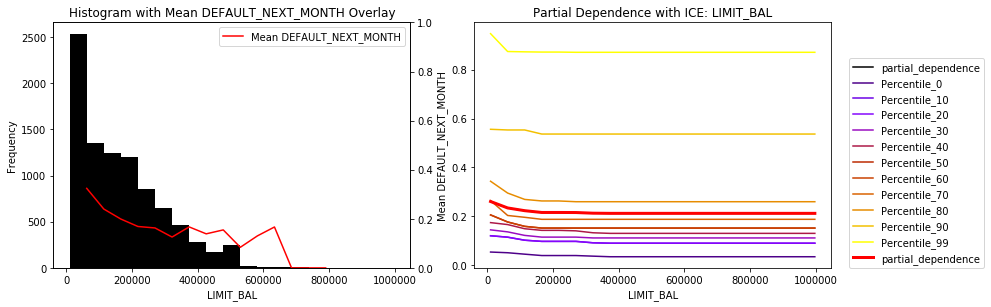

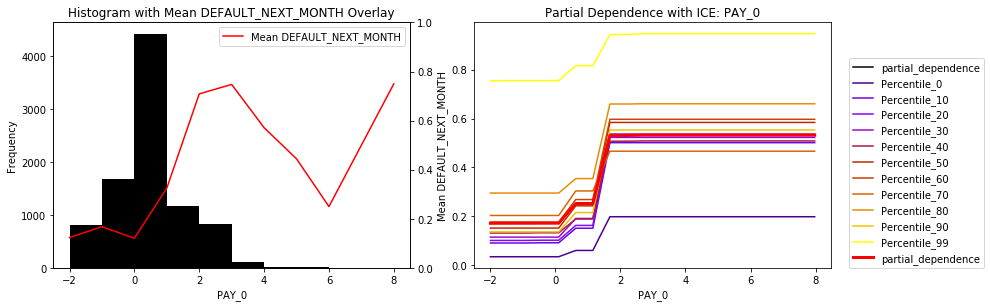

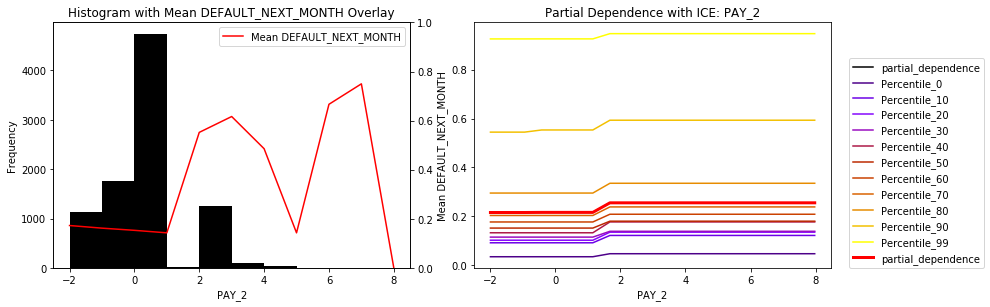

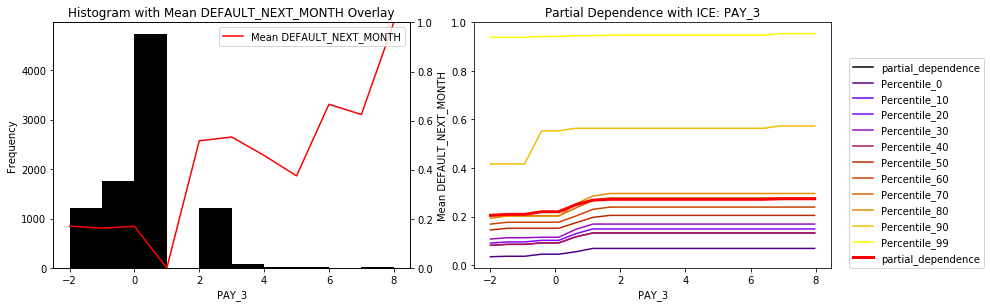

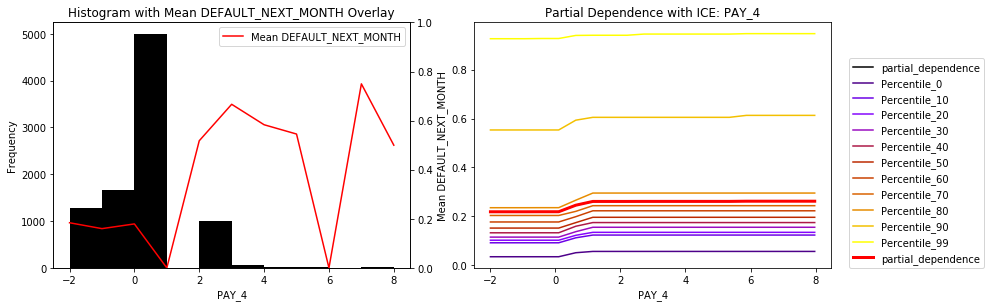

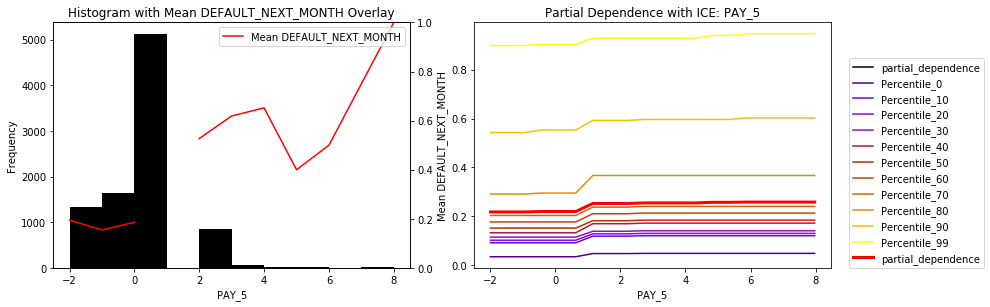

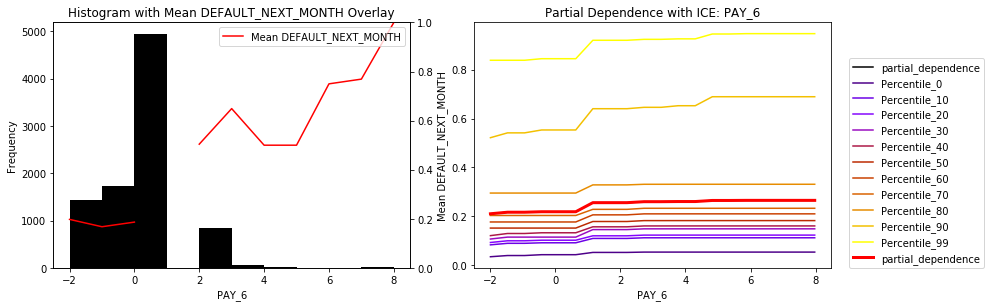

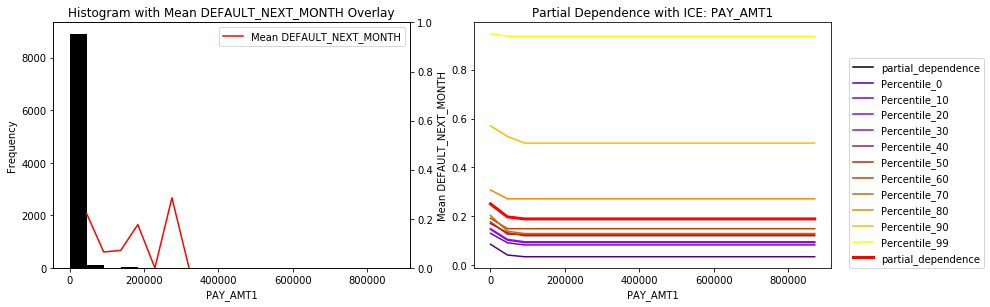

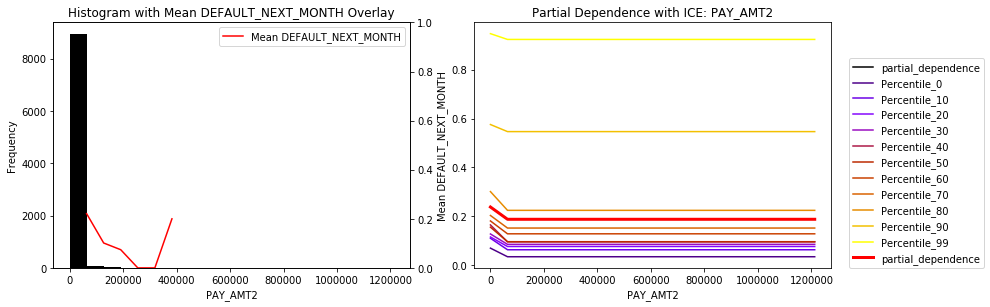

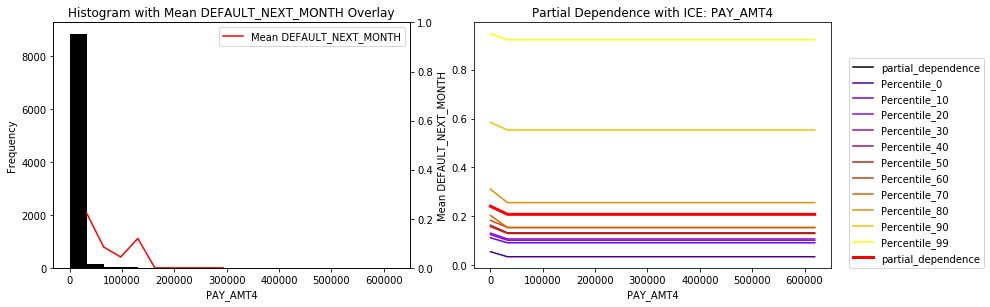

In [175]:
def diag_plot(xs):
    
    fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=1.8, wspace=0.18)

    if test[xs].nunique() <= 20:
        mean_df = test[[xs, y]].groupby(by=xs).mean()
        freq, bins, _ = ax.hist(test[xs], color='k')
    else: 
        temp_df = pd.concat([pd.cut(test[xs], pd_ice_dict[xs][xs]-1, duplicates='drop'), 
                             test[y]], axis=1)
        mean_df = temp_df.groupby(by=xs).mean()
        del temp_df
        freq, bins, _ = ax.hist(test[xs], bins=pd_ice_dict[xs][xs]-1, color='k')
        bins = bins[:-1]
        
    ax.set_xlabel(xs)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram with Mean ' + y + ' Overlay')
    ax1 = ax.twinx()
    _ = ax1.set_ylim((0,1))
    _ = ax1.plot(bins, mean_df.reindex(labels=bins)[y], color='r')
    _ = ax1.set_ylabel('Mean ' + y)
    _ = ax1.legend(['Mean ' + y], loc=1)

    # PD and ICE
    plot_par_dep_ICE(xs,
                 pd_ice_dict[xs],
                 ax2)
    _ = ax2.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

for xs in selected: 
    diag_plot(xs)

In [176]:
folds = 5
metric_list = ['mcc', 'F1', 'accuracy', 'logloss', 'auc']
model_list = ['best_glm', 'best_mgbm']

###

temp_df = test.copy(deep=True)
np.random.seed(seed=SEED)
temp_df['fold'] = np.random.randint(low=0, high=folds, size=temp_df.shape[0])

columns_ = ['Fold', 'Metric'] 
columns_ += [model + ' Value' for model in model_list]
#columns_ += [model + ' Rank' for model in model_list]

eval_frame = pd.DataFrame(columns=columns_)
i = 0

for fold in sorted(temp_df['fold'].unique()):
    for metric in sorted(metric_list):
        
        val_dict = {}
        for model in sorted(model_list):
            code = '%s.model_performance(h2o.H2OFrame(temp_df[temp_df["fold"] == %d])).%s()' % (model, fold, metric)
            key_ = model + ' Value'
            val_ = eval(code)
            if isinstance(val_, list):
                val_ = val_[0][1]
            val_dict[key_] = val_
        
        rank_list = list(val_dict.keys())
        #print(rank_list)
        
        val_dict.update({
            'Fold':fold,
            'Metric':metric,
             })
        
        eval_frame = eval_frame.append(val_dict, ignore_index=True)
        #print(eval_frame)
        #print(eval_frame.loc[i, rank_list])
        
        val_ = None           
        for val_ in sorted(rank_list):
            if eval_frame.loc[i, 'Metric'] == 'logloss':
                eval_frame.loc[i, val_.replace(' Value', ' Rank')] = eval_frame.loc[i, rank_list].rank()[val_]
            else:              
                eval_frame.loc[i, val_.replace(' Value', ' Rank')] = eval_frame.loc[i, rank_list].rank(ascending=False)[val_]

        i += 1
        
del temp_df

eval_frame

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |███████████

,Fold,Metric,best_glm Value,best_mgbm Value,best_glm Rank,best_mgbm Rank
0,0,F1,0.533181,0.551298,2.0,1.0
1,0,accuracy,0.816246,0.817367,2.0,1.0
2,0,auc,0.738625,0.776026,2.0,1.0
3,0,logloss,0.468678,0.440775,2.0,1.0
4,0,mcc,0.419924,0.420105,2.0,1.0
5,1,F1,0.540865,0.554762,2.0,1.0
6,1,accuracy,0.823882,0.826063,2.0,1.0
7,1,auc,0.729674,0.776877,2.0,1.0
8,1,logloss,0.465999,0.434170,2.0,1.0
9,1,mcc,0.432722,0.445354,2.0,1.0


In [178]:
# model 1
#print(eval_frame['best_glm Rank'].mean()) # 1.8 
#print(eval_frame['best_mgbm Rank'].mean()) # 1.2 <-- just allowing nonlinearity is helpful!

# model 2
#print(eval_frame['best_glm Rank'].mean()) # 1.92
#print(eval_frame['best_mgbm Rank'].mean()) # 1.08

# model 3
#print(eval_frame['best_glm Rank'].mean()) # 1.92
#print(eval_frame['best_mgbm Rank'].mean()) # 1.08

# model 4
#print(eval_frame['best_glm Rank'].mean()) # 1.96
#print(eval_frame['best_mgbm Rank'].mean()) # 1.04

# model 5
print(eval_frame['best_glm Rank'].mean()) # 2
print(eval_frame['best_mgbm Rank'].mean()) # 1

# model 6
#print(eval_frame['best_glm Rank'].mean()) # 2
#print(eval_frame['best_mgbm Rank'].mean()) # 1

2.0
1.0
